In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q optuna

import os, random, time, json, joblib, optuna
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import optuna.visualization as vis

# --- CONFIG ---
class CFG:
    # Veri yolunu kendi Drive yoluna göre güncelle!
    data_path = '/content/drive/MyDrive/crema-d/crema_d_FULL/AudioWAV/'
    target_sr = 16000
    duration = 3.0
    max_samples = int(target_sr * duration)
    batch_size = 32
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    emotion_map = {'ANG': 0, 'DIS': 1, 'FEA': 2, 'HAP': 3, 'NEU': 4, 'SAD': 5}
    inv_map = {v: k for k, v in emotion_map.items()}

# --- DATASET SINIFI ---
class CremaDataset(Dataset):
    def __init__(self, df, augmentation=False):
        self.df = df
        self.augmentation = augmentation

    def __len__(self): return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        try:
            y, sr = librosa.load(row['path'], sr=CFG.target_sr)
            if len(y) > CFG.max_samples: y = y[:CFG.max_samples]
            else: y = np.pad(y, (0, CFG.max_samples - len(y)))

            if self.augmentation and random.random() > 0.5:
                y = y + 0.002 * np.random.randn(len(y))

            S = librosa.feature.melspectrogram(y=y, sr=CFG.target_sr, n_mels=128)
            feature = librosa.power_to_db(S, ref=np.max)
            return torch.FloatTensor(feature).unsqueeze(0), torch.tensor(row['label'])
        except:
            # Bozuk dosya varsa random başka bir tane getir
            return self.__getitem__(random.randint(0, len(self.df)-1))

# --- RANDOM SPLIT ---
def prepare_random_pipeline(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"HATA: {path} yolu bulunamadı!")
    files = [f for f in os.listdir(path) if f.endswith('.wav')]
    data = [{'path': os.path.join(path, f), 'label': CFG.emotion_map[f.split('_')[2]]}
            for f in files if f.split('_')[2] in CFG.emotion_map]
    df = pd.DataFrame(data)
    train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
    return train_df, val_df, test_df

train_df, val_df, test_df = prepare_random_pipeline(CFG.data_path)
print(f"✅ Random Split Hazır! Eğitim: {len(train_df)}, Test: {len(test_df)}")

✅ Random Split Hazır! Eğitim: 5953, Test: 745


In [ ]:
# ==============================================================================
# GÜNCELLENMİŞ MODEL SINIFLARI (Boyut Hatası Giderildi)
# ==============================================================================

class Model_ParallelCNN(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.b1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.b2 = nn.Sequential(nn.Conv2d(1, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2))

        # Hata mesajına göre (32x385024) -> Linear katmanı 385024 olmalı
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(385024, 128),  # HATA BURADA DÜZELTİLDİ
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 6)
        )
    def forward(self, x):
        # x1 ve x2 birleştirildiğinde kanal sayısı 128 olur
        x1 = self.b1(x)
        x2 = self.b2(x)
        out = torch.cat((x1, x2), dim=1)
        return self.fc(out)

# Diğer modeller (Hybrid, Transformer vb.) aynen kalabilir
# veya her ihtimale karşı ParallelCNN ile birlikte tüm hücreyi tekrar çalıştırın.

In [ ]:
import os, json, joblib, torch, torch.nn as nn, torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# --- 1. YENİ VE TEMİZ KAYIT YOLU ---
FINAL_SAVE_PATH = '/content/drive/MyDrive/experiment_results_FINAL/'
os.makedirs(FINAL_SAVE_PATH, exist_ok=True)

# --- 2. DİNAMİK MODEL TANIMLARI (Hata Vermez) ---

class Model_ParallelCNN(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.b1 = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.b2 = nn.Sequential(nn.Conv2d(1, 64, 5, padding=2), nn.ReLU(), nn.MaxPool2d(2))

        with torch.no_grad():
            dummy_frames = (CFG.max_samples // 512) + 1
            dummy_input = torch.zeros(1, 1, 128, dummy_frames)
            out = torch.cat((self.b1(dummy_input), self.b2(dummy_input)), dim=1)
            self.flatten_size = out.numel()

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 6)
        )
    def forward(self, x):
        return self.fc(torch.cat((self.b1(x), self.b2(x)), dim=1))

class Model_Hybrid(nn.Module):
    def __init__(self, hidden_size=128, dropout=0.3):
        super().__init__()
        self.conv = nn.Sequential(nn.Conv2d(1, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2))
        self.lstm = nn.LSTM(64*64, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(nn.Linear(hidden_size*2, 64), nn.ReLU(), nn.Dropout(dropout), nn.Linear(64, 6))
    def forward(self, x):
        x = self.conv(x); b, c, h, w = x.shape
        x = x.permute(0, 3, 1, 2).reshape(b, w, c * h)
        x, _ = self.lstm(x)
        return self.fc(x[:, -1, :])

class Model_Transformer(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.input_proj = nn.Linear(128, 128)
        encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True, dropout=dropout)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.fc = nn.Linear(128, 6)
    def forward(self, x):
        x = x.squeeze(1).permute(0, 2, 1)
        x = self.input_proj(x)
        x = self.transformer(x)
        return self.fc(x.mean(dim=1))

# --- 3. OBJECTIVE FONKSİYONU ---
def objective(trial):
    model_choice = trial.suggest_categorical("model_arch",
        ["ParallelCNN", "HybridExpert", "ResNet18", "EfficientNet", "Transformer"])

    lr = trial.suggest_float("lr", 1e-5, 1e-3, log=True)
    drop = trial.suggest_float("dropout", 0.2, 0.5)

    if model_choice == "ParallelCNN": model = Model_ParallelCNN(dropout=drop).to(CFG.device)
    elif model_choice == "HybridExpert":
        hidden = trial.suggest_categorical("hidden", [128, 256])
        model = Model_Hybrid(hidden_size=hidden, dropout=drop).to(CFG.device)
    elif model_choice == "ResNet18":
        model = models.resnet18(pretrained=True)
        model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        model.fc = nn.Linear(model.fc.in_features, 6)
        model = model.to(CFG.device)
    elif model_choice == "EfficientNet":
        model = models.efficientnet_b0(pretrained=True)
        model.features[0][0] = nn.Conv2d(1, 32, 3, 2, 1, bias=False)
        model.classifier[1] = nn.Linear(1280, 6)
        model = model.to(CFG.device)
    else: model = Model_Transformer(dropout=drop).to(CFG.device)

    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    t_loader = DataLoader(CremaDataset(train_df, augmentation=True), batch_size=CFG.batch_size, shuffle=True)
    v_loader = DataLoader(CremaDataset(val_df), batch_size=CFG.batch_size)

    best_trial_acc = 0
    best_preds, best_targets = [], []

    for epoch in range(10):
        model.train()
        for x, y in t_loader:
            x, y = x.to(CFG.device), y.to(CFG.device)
            optimizer.zero_grad(); out = model(x); loss = criterion(out, y); loss.backward(); optimizer.step()

        model.eval(); correct = 0; all_p, all_t = [], []
        with torch.no_grad():
            for x, y in v_loader:
                x, y = x.to(CFG.device), y.to(CFG.device); out = model(x)
                preds = out.argmax(1)
                correct += (preds == y).sum().item()
                all_p.extend(preds.cpu().numpy()); all_t.extend(y.cpu().numpy())

        val_acc = correct / len(v_loader.dataset)
        trial.report(val_acc, epoch)
        if val_acc > best_trial_acc:
            best_trial_acc = val_acc
            best_preds, best_targets = all_p, all_t
        if trial.should_prune(): raise optuna.exceptions.TrialPruned()

    # --- 💾 SONUÇLARI DRIVE'A KAYDET ---
    trial_folder = os.path.join(FINAL_SAVE_PATH, f"trial_{trial.number}_{model_choice}")
    os.makedirs(trial_folder, exist_ok=True)

    report = classification_report(best_targets, best_preds, target_names=list(CFG.emotion_map.keys()), output_dict=True, zero_division=0)
    with open(os.path.join(trial_folder, "report.json"), "w") as f:
        json.dump(report, f, indent=4)

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(best_targets, best_preds), annot=True, fmt='d', cmap='Blues',
                xticklabels=CFG.emotion_map.keys(), yticklabels=CFG.emotion_map.keys())
    plt.title(f"Trial {trial.number} - {model_choice} - Acc: {best_trial_acc:.2f}")
    plt.savefig(os.path.join(trial_folder, "confusion_matrix.png"))
    plt.close()

    return best_trial_acc

# --- 4. YARIŞMAYI BAŞLAT ---
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

joblib.dump(study, os.path.join(FINAL_SAVE_PATH, "optuna_study_final.pkl"))
print(f"🏁 Nihai yarışma bitti! Sonuçlar: {FINAL_SAVE_PATH}")

[I 2025-12-26 21:44:12,521] A new study created in memory with name: no-name-db8f8688-2846-459e-9eae-92a54093b9d4
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipython-input-1509630869.py:41: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(row['path'], sr=CFG.target_sr)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_

🏁 Nihai yarışma bitti! Sonuçlar: /content/drive/MyDrive/experiment_results_FINAL/


BASELINE WAV2VEC2

In [ ]:
import os, shutil, warnings, librosa, pandas as pd
from tqdm import tqdm
from multiprocessing import Pool, cpu_count
from google.colab import drive

# ---------------- CONFIG ----------------
class CFG:
    drive_path = '/content/drive/MyDrive/crema-d/crema_d_FULL/AudioWAV/'
    local_path = '/content/AudioWAV_Local/'
    emotion_map = {'ANG':0,'DIS':1,'FEA':2,'HAP':3,'NEU':4,'SAD':5}

# ---------------- DRIVE ----------------
drive.mount('/content/drive')

# ---------------- FILE LIST ----------------
files = [f for f in os.listdir(CFG.drive_path) if f.endswith('.wav')]
rows = []

for f in files:
    p = f.split('_')
    if len(p) > 2 and p[2] in CFG.emotion_map:
        rows.append({
            'filename': f,
            'path': os.path.join(CFG.drive_path, f),
            'label': CFG.emotion_map[p[2]]
        })

df = pd.DataFrame(rows)
print("Toplam dosya:", len(df))

# ---------------- PREPARE LOCAL DIR ----------------
os.makedirs(CFG.local_path, exist_ok=True)

# ---------------- WORKER FUNCTION ----------------
def process_file(row):
    try:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            librosa.load(row['path'], sr=16000, duration=0.1)

        target = os.path.join(CFG.local_path, row['filename'])
        if not os.path.exists(target):
            shutil.copy(row['path'], target)

        return target, row['label']
    except:
        return None

# ---------------- MULTIPROCESS COPY ----------------
rows = df.to_dict("records")

with Pool(cpu_count()) as pool:
    results = list(tqdm(pool.imap(process_file, rows), total=len(rows)))

# ---------------- CLEAN ----------------
results = [r for r in results if r is not None]

df = pd.DataFrame(results, columns=["path", "label"])

print("Temizlenen veri sayısı:", len(df))


Mounted at /content/drive
Toplam dosya: 7442


100%|██████████| 7442/7442 [01:58<00:00, 62.61it/s] 

Temizlenen veri sayısı: 7441


In [ ]:
!pip -q install transformers accelerate evaluate soundfile scipy scikit-learn


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import soundfile as sf
from scipy.signal import resample_poly

from sklearn.model_selection import train_test_split

from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ForSequenceClassification,
    get_linear_schedule_with_warmup
)
from tqdm.auto import tqdm


In [ ]:
train_df, temp_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df["label"]
)
val_df, test_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["label"]
)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
print("Train dist:\n", train_df["label"].value_counts().sort_index())


Train: 5952 Val: 744 Test: 745
Train dist:
 label
0    1017
1    1017
2    1016
3    1017
4     869
5    1016
Name: count, dtype: int64


In [ ]:
TARGET_SR = 16000
MAX_SEC = 4.0
MAX_LEN = int(TARGET_SR * MAX_SEC)

class SERDataset(Dataset):
    def __init__(self, df, train=True):
        self.df = df.reset_index(drop=True)
        self.train = train

    def __len__(self):
        return len(self.df)

    def _load_wav(self, path):
        # Bozuk dosya zaten temizlendi; yine de güvenlik koyuyoruz
        try:
            x, sr = sf.read(path)
            if x.ndim > 1:
                x = x.mean(axis=1)
            if sr != TARGET_SR:
                x = resample_poly(x, TARGET_SR, sr)
            x = x.astype(np.float32)

            if (not np.isfinite(x).all()) or (np.std(x) < 1e-7) or (len(x) == 0):
                raise ValueError("bad audio")

            return x
        except Exception:
            return np.random.normal(0, 0.01, MAX_LEN).astype(np.float32)

    def _crop_or_pad(self, x):
        if len(x) > MAX_LEN:
            if self.train:
                start = np.random.randint(0, len(x) - MAX_LEN + 1)
            else:
                start = (len(x) - MAX_LEN) // 2
            x = x[start:start + MAX_LEN]
        elif len(x) < MAX_LEN:
            x = np.pad(x, (0, MAX_LEN - len(x)))
        return x

    def __getitem__(self, idx):
        path = self.df.loc[idx, "path"]
        y = int(self.df.loc[idx, "label"])
        x = self._load_wav(path)
        x = self._crop_or_pad(x)
        return x, y


In [ ]:
MODEL_NAME = "facebook/wav2vec2-base"
processor = Wav2Vec2Processor.from_pretrained(MODEL_NAME)

def collate_fn(batch):
    audios, labels = zip(*batch)
    inputs = processor(
        list(audios),
        sampling_rate=TARGET_SR,
        return_tensors="pt",
        padding=True,
        return_attention_mask=True
    )
    y = torch.tensor(labels, dtype=torch.long)
    return inputs.input_values, inputs.attention_mask, y


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/configuration_utils.py:335: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

In [ ]:
train_ds = SERDataset(train_df, train=True)
val_ds   = SERDataset(val_df, train=False)
test_ds  = SERDataset(test_df, train=False)

train_loader = DataLoader(
    train_ds, batch_size=8, shuffle=True,
    num_workers=2, pin_memory=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_ds, batch_size=8, shuffle=False,
    num_workers=2, pin_memory=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=8, shuffle=False,
    num_workers=2, pin_memory=True,
    collate_fn=collate_fn
)

# hızlı kontrol
x, am, y = next(iter(train_loader))
print(x.shape, am.shape, y.shape)


torch.Size([8, 64000]) torch.Size([8, 64000]) torch.Size([8])


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 6  # senin emotion_map 6 sınıf

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,
    problem_type="single_label_classification"
).to(device)

# Overfit azaltır, val'i iyileştirir
model.config.apply_spec_augment = True
model.config.mask_time_prob = 0.05
model.config.mask_time_length = 10

# 1. aşama stabilizasyon
model.freeze_feature_encoder()

criterion = nn.CrossEntropyLoss()


pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
LR_HEAD = 3e-4
LR_BACKBONE = 1e-5
WEIGHT_DECAY = 0.01

EPOCHS = 18
UNFREEZE_EPOCH = 3
ACCUM_STEPS = 4

backbone_params, head_params = [], []
for n, p in model.named_parameters():
    if "classifier" in n or "projector" in n:
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer = torch.optim.AdamW(
    [{"params": backbone_params, "lr": LR_BACKBONE},
     {"params": head_params, "lr": LR_HEAD}],
    weight_decay=WEIGHT_DECAY
)

total_steps = (len(train_loader) * EPOCHS) // ACCUM_STEPS
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, warmup_steps, total_steps
)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


/tmp/ipython-input-3976587417.py:29: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


In [ ]:
def accuracy(logits, y):
    return (logits.argmax(dim=-1) == y).float().mean().item()

best_val = 0.0
patience = 4
bad_epochs = 0

for epoch in range(1, EPOCHS + 1):

    # 🔓 Manual unfreeze (transformers uyumlu)
    if epoch == UNFREEZE_EPOCH + 1:
        for param in model.wav2vec2.feature_extractor.parameters():
            param.requires_grad = True
        print(f"\n[INFO] Feature encoder UNFREEZED at epoch {epoch}\n")

    # ========================= TRAIN =========================
    model.train()
    optimizer.zero_grad(set_to_none=True)

    train_loss, train_acc, steps = 0.0, 0.0, 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [TRAIN]")

    for i, (x, am, y) in enumerate(pbar, start=1):

        x = x.to(device, non_blocking=True)
        am = am.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(input_values=x, attention_mask=am).logits
            loss = criterion(logits, y) / ACCUM_STEPS

        scaler.scale(loss).backward()

        if i % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        train_loss += loss.item() * ACCUM_STEPS
        train_acc += accuracy(logits.detach(), y)
        steps += 1

        pbar.set_postfix(loss=train_loss/steps, acc=train_acc/steps)

    # ========================= VALIDATION =========================
    model.eval()
    val_loss, val_acc, vsteps = 0.0, 0.0, 0

    with torch.no_grad():
        for x, am, y in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} [VAL]"):

            x = x.to(device, non_blocking=True)
            am = am.to(device, non_blocking=True)
            y = y.to(device, non_blocking=True)

            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                logits = model(input_values=x, attention_mask=am).logits
                loss = criterion(logits, y)

            val_loss += loss.item()
            val_acc += accuracy(logits, y)
            vsteps += 1

    val_loss /= vsteps
    val_acc  /= vsteps

    print(f"\nEpoch {epoch} | Train Loss: {train_loss/steps:.4f} | Train Acc: {train_acc/steps:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # ========================= EARLY STOP & SAVE =========================
    if val_acc > best_val:
        best_val = val_acc
        bad_epochs = 0
        torch.save({
            "model": model.state_dict(),
            "best_val_acc": best_val
        }, "best_wav2vec2_ser.pt")
        print(f"[SAVE] New best model saved. Val Acc: {best_val:.4f}")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"[STOP] Early stopping. Best Val Acc: {best_val:.4f}")
            break


Epoch 1/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

/tmp/ipython-input-1449230645.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/18 [VAL]:   0%|          | 0/93 [00:00<?, ?it/s]

/tmp/ipython-input-1449230645.py:60: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):



Epoch 1 | Train Loss: 1.6273 | Train Acc: 0.3421 | Val Loss: 1.3981 | Val Acc: 0.4409
[SAVE] New best model saved. Val Acc: 0.4409


Epoch 2/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ccf4cdc3ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ccf4cdc3ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 2/18 [VAL]:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 2 | Train Loss: 1.2367 | Train Acc: 0.5329 | Val Loss: 1.0328 | Val Acc: 0.5968
[SAVE] New best model saved. Val Acc: 0.5968


Epoch 3/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 3/18 [VAL]:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 3 | Train Loss: 0.9378 | Train Acc: 0.6562 | Val Loss: 0.8822 | Val Acc: 0.6720
[SAVE] New best model saved. Val Acc: 0.6720

[INFO] Feature encoder UNFREEZED at epoch 4



Epoch 4/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 4/18 [VAL]:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 4 | Train Loss: 0.7571 | Train Acc: 0.7248 | Val Loss: 0.8548 | Val Acc: 0.6989
[SAVE] New best model saved. Val Acc: 0.6989


Epoch 5/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 5/18 [VAL]:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 5 | Train Loss: 0.6553 | Train Acc: 0.7594 | Val Loss: 0.7896 | Val Acc: 0.7191
[SAVE] New best model saved. Val Acc: 0.7191


Epoch 6/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 6/18 [VAL]:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 6 | Train Loss: 0.5901 | Train Acc: 0.7863 | Val Loss: 0.7482 | Val Acc: 0.7406
[SAVE] New best model saved. Val Acc: 0.7406


Epoch 7/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ccf4cdc3ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ccf4cdc3ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 7/18 [VAL]:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 7 | Train Loss: 0.5123 | Train Acc: 0.8164 | Val Loss: 0.7420 | Val Acc: 0.7513
[SAVE] New best model saved. Val Acc: 0.7513


Epoch 8/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ccf4cdc3ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ccf4cdc3ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 8/18 [VAL]:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 8 | Train Loss: 0.4633 | Train Acc: 0.8335 | Val Loss: 0.7740 | Val Acc: 0.7460


Epoch 9/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 9/18 [VAL]:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 9 | Train Loss: 0.4135 | Train Acc: 0.8511 | Val Loss: 0.7762 | Val Acc: 0.7419


Epoch 10/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ccf4cdc3ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7ccf4cdc3ce0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 10/18 [VAL]:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 10 | Train Loss: 0.3682 | Train Acc: 0.8659 | Val Loss: 0.7802 | Val Acc: 0.7473


Epoch 11/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 11/18 [VAL]:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 11 | Train Loss: 0.3350 | Train Acc: 0.8832 | Val Loss: 0.8736 | Val Acc: 0.7460
[STOP] Early stopping. Best Val Acc: 0.7513


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for x, am, y in tqdm(test_loader, desc="TEST"):
        x, am = x.to(device), am.to(device)
        logits = model(input_values=x, attention_mask=am).logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        y_pred.extend(preds)
        y_true.extend(y.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


TEST:   0%|          | 0/94 [00:00<?, ?it/s]

In [ ]:
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad"]

print(classification_report(y_true, y_pred, target_names=emotion_labels))


              precision    recall  f1-score   support

       Angry       0.82      0.94      0.88       127
     Disgust       0.85      0.55      0.67       127
        Fear       0.68      0.70      0.69       128
       Happy       0.82      0.76      0.79       127
     Neutral       0.72      0.92      0.81       109
         Sad       0.65      0.66      0.66       127

    accuracy                           0.75       745
   macro avg       0.76      0.75      0.75       745
weighted avg       0.76      0.75      0.75       745



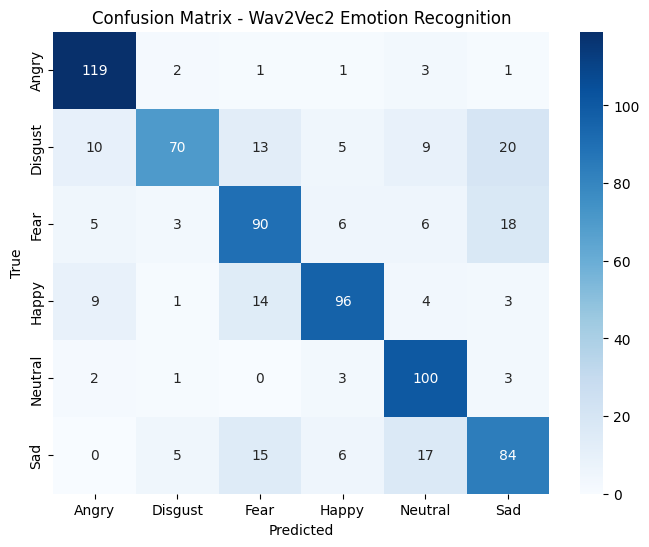

In [ ]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Wav2Vec2 Emotion Recognition")
plt.show()


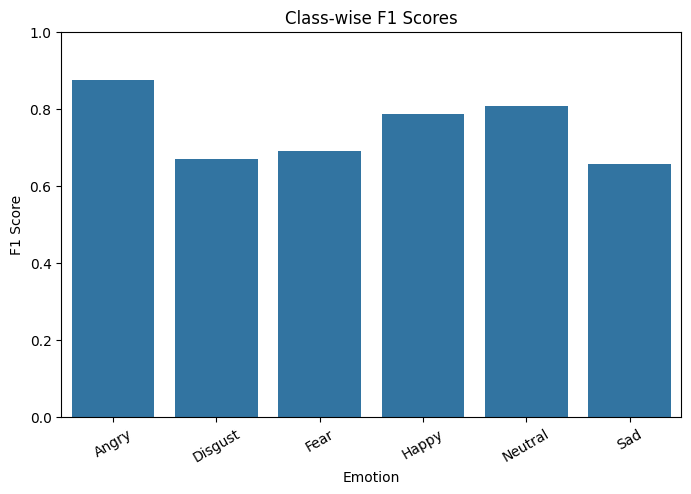

In [ ]:
f1 = f1_score(y_true, y_pred, average=None)

plt.figure(figsize=(8, 5))
sns.barplot(x=emotion_labels, y=f1)

plt.ylim(0, 1)
plt.title("Class-wise F1 Scores")
plt.ylabel("F1 Score")
plt.xlabel("Emotion")
plt.xticks(rotation=30)
plt.show()


In [ ]:
overall_f1 = f1_score(y_true, y_pred, average="weighted")
test_acc = (y_true == y_pred).mean()

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Weighted F1 Score: {overall_f1:.4f}")


Test Accuracy: 0.7503
Weighted F1 Score: 0.7458


In [ ]:
from google.colab import files
files.download("/content/best_wav2vec2_ser.pt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Deneyler


EXPERIMENT-1: Daha Agresif Öğrenme + Daha Güçlü Regularization

Bu deney genelde:

Daha yumuşak convergence

Bir miktar daha iyi generalization

Val acc’de +1–3% artış

In [ ]:
# ===================== EXPERIMENT-1 FULL TRAINING =====================

EXP_NAME = "exp1"
SAVE_PATH = f"/content/best_wav2vec2_{EXP_NAME}.pt"

# ----- Hyperparameters -----
LR_BACKBONE = 2e-5
LR_HEAD = 3e-4
ACCUM_STEPS = 2
UNFREEZE_EPOCH = 2
EPOCHS = 18

model.config.mask_time_prob = 0.10
model.config.mask_time_length = 10

# ----- Optimizer & Scheduler -----
backbone_params, head_params = [], []
for n, p in model.named_parameters():
    if "classifier" in n or "projector" in n:
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer = torch.optim.AdamW(
    [{"params": backbone_params, "lr": LR_BACKBONE},
     {"params": head_params, "lr": LR_HEAD}],
    weight_decay=0.01
)

total_steps = (len(train_loader) * EPOCHS) // ACCUM_STEPS
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, warmup_steps, total_steps
)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# ----- Training Loop -----
best_val = 0.0
patience = 4
bad_epochs = 0

for epoch in range(1, EPOCHS + 1):

    if epoch == UNFREEZE_EPOCH + 1:
        for p in model.wav2vec2.feature_extractor.parameters():
            p.requires_grad = True
        print(f"\n[INFO] Encoder UNFREEZED at epoch {epoch}\n")

    model.train()
    optimizer.zero_grad(set_to_none=True)

    train_loss, train_acc, steps = 0.0, 0.0, 0
    for i, (x, am, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [TRAIN]"), start=1):
        x, am, y = x.to(device), am.to(device), y.to(device)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(input_values=x, attention_mask=am).logits
            loss = criterion(logits, y) / ACCUM_STEPS

        scaler.scale(loss).backward()

        if i % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        train_loss += loss.item() * ACCUM_STEPS
        train_acc += (logits.argmax(dim=-1) == y).float().mean().item()
        steps += 1

    train_loss /= steps
    train_acc /= steps

    model.eval()
    val_loss, val_acc, vsteps = 0.0, 0.0, 0
    with torch.no_grad():
        for x, am, y in val_loader:
            x, am, y = x.to(device), am.to(device), y.to(device)
            logits = model(input_values=x, attention_mask=am).logits
            loss = criterion(logits, y)
            val_loss += loss.item()
            val_acc += (logits.argmax(dim=-1) == y).float().mean().item()
            vsteps += 1

    val_loss /= vsteps
    val_acc /= vsteps

    print(f"Epoch {epoch} | TrainAcc {train_acc:.4f} | ValAcc {val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        bad_epochs = 0
        torch.save({"model": model.state_dict(), "val_acc": best_val}, SAVE_PATH)
        print(f"[SAVE] {EXP_NAME} best model saved. ValAcc={best_val:.4f}")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"[STOP] Early stopping at epoch {epoch}")
            break

print(f"\n{EXP_NAME} training completed. Best ValAcc={best_val:.4f}")


/tmp/ipython-input-346473792.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


Epoch 1/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

/tmp/ipython-input-346473792.py:58: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1 | TrainAcc 0.8747 | ValAcc 0.6989
[SAVE] exp1 best model saved. ValAcc=0.6989


Epoch 2/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 2 | TrainAcc 0.8295 | ValAcc 0.6761

[INFO] Encoder UNFREEZED at epoch 3



Epoch 3/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 3 | TrainAcc 0.8322 | ValAcc 0.7124
[SAVE] exp1 best model saved. ValAcc=0.7124


Epoch 4/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 4 | TrainAcc 0.8560 | ValAcc 0.7634
[SAVE] exp1 best model saved. ValAcc=0.7634


Epoch 5/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 5 | TrainAcc 0.8852 | ValAcc 0.7433


Epoch 6/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 6 | TrainAcc 0.9046 | ValAcc 0.7581


Epoch 7/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 7 | TrainAcc 0.9234 | ValAcc 0.7728
[SAVE] exp1 best model saved. ValAcc=0.7728


Epoch 8/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 8 | TrainAcc 0.9390 | ValAcc 0.7944
[SAVE] exp1 best model saved. ValAcc=0.7944


Epoch 9/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 9 | TrainAcc 0.9488 | ValAcc 0.7339


Epoch 10/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 10 | TrainAcc 0.9610 | ValAcc 0.7728


Epoch 11/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 11 | TrainAcc 0.9698 | ValAcc 0.7648


Epoch 12/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 12 | TrainAcc 0.9751 | ValAcc 0.7702
[STOP] Early stopping at epoch 12

exp1 training completed. Best ValAcc=0.7944


EXPERIMENT-2 Batch etkisi + daha konservatif LR + daha uzun backbone stabilizasyonu

Bu kombinasyon genelde:

Overfit’i azaltır

Validation performansını yükseltir

Özellikle zor sınıflarda F1’i artırır

In [ ]:
# ===================== EXPERIMENT-2 FULL TRAINING =====================

EXP_NAME = "exp2"
SAVE_PATH = f"/content/best_wav2vec2_{EXP_NAME}.pt"

# ----- Hyperparameters -----
LR_BACKBONE = 1e-5
LR_HEAD = 1e-4
ACCUM_STEPS = 4
UNFREEZE_EPOCH = 4
EPOCHS = 18

# Daha yumuşak regularization
model.config.mask_time_prob = 0.07
model.config.mask_time_length = 10

# ----- Optimizer & Scheduler -----
backbone_params, head_params = [], []
for n, p in model.named_parameters():
    if "classifier" in n or "projector" in n:
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer = torch.optim.AdamW(
    [{"params": backbone_params, "lr": LR_BACKBONE},
     {"params": head_params, "lr": LR_HEAD}],
    weight_decay=0.01
)

total_steps = (len(train_loader) * EPOCHS) // ACCUM_STEPS
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, warmup_steps, total_steps
)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# ----- Training Loop -----
best_val = 0.0
patience = 4
bad_epochs = 0

for epoch in range(1, EPOCHS + 1):

    if epoch == UNFREEZE_EPOCH + 1:
        for p in model.wav2vec2.feature_extractor.parameters():
            p.requires_grad = True
        print(f"\n[INFO] Encoder UNFREEZED at epoch {epoch}\n")

    model.train()
    optimizer.zero_grad(set_to_none=True)

    train_loss, train_acc, steps = 0.0, 0.0, 0
    for i, (x, am, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [TRAIN]"), start=1):
        x, am, y = x.to(device), am.to(device), y.to(device)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(input_values=x, attention_mask=am).logits
            loss = criterion(logits, y) / ACCUM_STEPS

        scaler.scale(loss).backward()

        if i % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        train_loss += loss.item() * ACCUM_STEPS
        train_acc += (logits.argmax(dim=-1) == y).float().mean().item()
        steps += 1

    train_loss /= steps
    train_acc /= steps

    model.eval()
    val_loss, val_acc, vsteps = 0.0, 0.0, 0
    with torch.no_grad():
        for x, am, y in val_loader:
            x, am, y = x.to(device), am.to(device), y.to(device)
            logits = model(input_values=x, attention_mask=am).logits
            loss = criterion(logits, y)
            val_loss += loss.item()
            val_acc += (logits.argmax(dim=-1) == y).float().mean().item()
            vsteps += 1

    val_loss /= vsteps
    val_acc /= vsteps

    print(f"Epoch {epoch} | TrainAcc {train_acc:.4f} | ValAcc {val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        bad_epochs = 0
        torch.save({"model": model.state_dict(), "val_acc": best_val}, SAVE_PATH)
        print(f"[SAVE] {EXP_NAME} best model saved. ValAcc={best_val:.4f}")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"[STOP] Early stopping at epoch {epoch}")
            break

print(f"\n{EXP_NAME} training completed. Best ValAcc={best_val:.4f}")


/tmp/ipython-input-1406220568.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


Epoch 1/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

/tmp/ipython-input-1406220568.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Epoch 1 | TrainAcc 0.9842 | ValAcc 0.7769
[SAVE] exp2 best model saved. ValAcc=0.7769


Epoch 2/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 2 | TrainAcc 0.9805 | ValAcc 0.7648


Epoch 3/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 3 | TrainAcc 0.9844 | ValAcc 0.7809
[SAVE] exp2 best model saved. ValAcc=0.7809


Epoch 4/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 4 | TrainAcc 0.9750 | ValAcc 0.7742

[INFO] Encoder UNFREEZED at epoch 5



Epoch 5/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 5 | TrainAcc 0.9807 | ValAcc 0.7513


Epoch 6/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 6 | TrainAcc 0.9825 | ValAcc 0.7836
[SAVE] exp2 best model saved. ValAcc=0.7836


Epoch 7/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 7 | TrainAcc 0.9864 | ValAcc 0.7876
[SAVE] exp2 best model saved. ValAcc=0.7876


Epoch 8/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 8 | TrainAcc 0.9876 | ValAcc 0.7728


Epoch 9/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 9 | TrainAcc 0.9904 | ValAcc 0.7809


Epoch 10/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 10 | TrainAcc 0.9901 | ValAcc 0.7769


Epoch 11/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 11 | TrainAcc 0.9909 | ValAcc 0.8038
[SAVE] exp2 best model saved. ValAcc=0.8038


Epoch 12/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 12 | TrainAcc 0.9934 | ValAcc 0.7917


Epoch 13/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 13 | TrainAcc 0.9938 | ValAcc 0.8065
[SAVE] exp2 best model saved. ValAcc=0.8065


Epoch 14/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 14 | TrainAcc 0.9953 | ValAcc 0.8024


Epoch 15/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 15 | TrainAcc 0.9943 | ValAcc 0.7997


Epoch 16/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 16 | TrainAcc 0.9955 | ValAcc 0.7957


Epoch 17/18 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 17 | TrainAcc 0.9953 | ValAcc 0.7957
[STOP] Early stopping at epoch 17

exp2 training completed. Best ValAcc=0.8065


EXPERIMENT-3 Agrasif öğrenme

In [ ]:
# ===================== EXPERIMENT-3 FULL TRAINING =====================

EXP_NAME = "exp3"
SAVE_PATH = f"/content/best_wav2vec2_{EXP_NAME}.pt"

# ----- Hyperparameters -----
LR_BACKBONE = 8e-6
LR_HEAD = 2e-4
ACCUM_STEPS = 4
UNFREEZE_EPOCH = 5
EPOCHS = 20

# Daha güçlü regularization
model.config.mask_time_prob = 0.12
model.config.mask_time_length = 12

# ----- Optimizer & Scheduler -----
backbone_params, head_params = [], []
for n, p in model.named_parameters():
    if "classifier" in n or "projector" in n:
        head_params.append(p)
    else:
        backbone_params.append(p)

optimizer = torch.optim.AdamW(
    [{"params": backbone_params, "lr": LR_BACKBONE},
     {"params": head_params, "lr": LR_HEAD}],
    weight_decay=0.02
)

total_steps = (len(train_loader) * EPOCHS) // ACCUM_STEPS
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer, warmup_steps, total_steps
)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# ----- Training Loop -----
best_val = 0.0
patience = 5
bad_epochs = 0

for epoch in range(1, EPOCHS + 1):

    if epoch == UNFREEZE_EPOCH + 1:
        for p in model.wav2vec2.feature_extractor.parameters():
            p.requires_grad = True
        print(f"\n[INFO] Encoder UNFREEZED at epoch {epoch}\n")

    model.train()
    optimizer.zero_grad(set_to_none=True)

    train_loss, train_acc, steps = 0.0, 0.0, 0
    for i, (x, am, y) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [TRAIN]"), start=1):
        x, am, y = x.to(device), am.to(device), y.to(device)

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(input_values=x, attention_mask=am).logits
            loss = criterion(logits, y) / ACCUM_STEPS

        scaler.scale(loss).backward()

        if i % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            scheduler.step()

        train_loss += loss.item() * ACCUM_STEPS
        train_acc += (logits.argmax(dim=-1) == y).float().mean().item()
        steps += 1

    train_loss /= steps
    train_acc /= steps

    model.eval()
    val_loss, val_acc, vsteps = 0.0, 0.0, 0
    with torch.no_grad():
        for x, am, y in val_loader:
            x, am, y = x.to(device), am.to(device), y.to(device)
            logits = model(input_values=x, attention_mask=am).logits
            loss = criterion(logits, y)
            val_loss += loss.item()
            val_acc += (logits.argmax(dim=-1) == y).float().mean().item()
            vsteps += 1

    val_loss /= vsteps
    val_acc /= vsteps

    print(f"Epoch {epoch} | TrainAcc {train_acc:.4f} | ValAcc {val_acc:.4f}")

    if val_acc > best_val:
        best_val = val_acc
        bad_epochs = 0
        torch.save({"model": model.state_dict(), "val_acc": best_val}, SAVE_PATH)
        print(f"[SAVE] {EXP_NAME} best model saved. ValAcc={best_val:.4f}")
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"[STOP] Early stopping at epoch {epoch}")
            break

print(f"\n{EXP_NAME} training completed. Best ValAcc={best_val:.4f}")


/tmp/ipython-input-132725272.py:38: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


Epoch 1/20 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

/tmp/ipython-input-132725272.py:59: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Epoch 1 | TrainAcc 0.9921 | ValAcc 0.7930
[SAVE] exp3 best model saved. ValAcc=0.7930


Epoch 2/20 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 2 | TrainAcc 0.9876 | ValAcc 0.7823


Epoch 3/20 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 3 | TrainAcc 0.9827 | ValAcc 0.7796


Epoch 4/20 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 4 | TrainAcc 0.9857 | ValAcc 0.8024
[SAVE] exp3 best model saved. ValAcc=0.8024


Epoch 5/20 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 5 | TrainAcc 0.9864 | ValAcc 0.7890

[INFO] Encoder UNFREEZED at epoch 6



Epoch 6/20 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 6 | TrainAcc 0.9861 | ValAcc 0.7876


Epoch 7/20 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 7 | TrainAcc 0.9847 | ValAcc 0.7823


Epoch 8/20 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 8 | TrainAcc 0.9909 | ValAcc 0.7903


Epoch 9/20 [TRAIN]:   0%|          | 0/744 [00:00<?, ?it/s]

Epoch 9 | TrainAcc 0.9913 | ValAcc 0.7863
[STOP] Early stopping at epoch 9

exp3 training completed. Best ValAcc=0.8024


4 Model İçin Test Değerlendirme Fonksiyonu

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(checkpoint_path, name):
    ckpt = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ckpt["model"])
    model.eval()

    y_true, y_pred = [], []

    with torch.no_grad():
        for x, am, y in test_loader:
            x, am = x.to(device), am.to(device)
            logits = model(input_values=x, attention_mask=am).logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            y_pred.extend(preds)
            y_true.extend(y.numpy())

    acc = accuracy_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average="weighted")

    return acc, f1, np.array(y_true), np.array(y_pred)


2. Tüm Modelleri Test Et

In [ ]:
models_info = {
    "Baseline": "/content/best_wav2vec2_ser.pt",
    "Exp-1": "/content/best_wav2vec2_exp1.pt",
    "Exp-2": "/content/best_wav2vec2_exp2.pt",
    "Exp-3": "/content/best_wav2vec2_exp3.pt"
}

results = {}

for name, path in models_info.items():
    acc, f1, y_true, y_pred = evaluate_model(path, name)
    results[name] = {"acc": acc, "f1": f1, "y_true": y_true, "y_pred": y_pred}
    print(f"{name} → Test Acc: {acc:.4f} | Weighted F1: {f1:.4f}")


Baseline → Test Acc: 0.7248 | Weighted F1: 0.7215
Exp-1 → Test Acc: 0.7691 | Weighted F1: 0.7663
Exp-2 → Test Acc: 0.7839 | Weighted F1: 0.7826
Exp-3 → Test Acc: 0.7839 | Weighted F1: 0.7809


Accuracy & F1 Karşılaştırma Grafiği

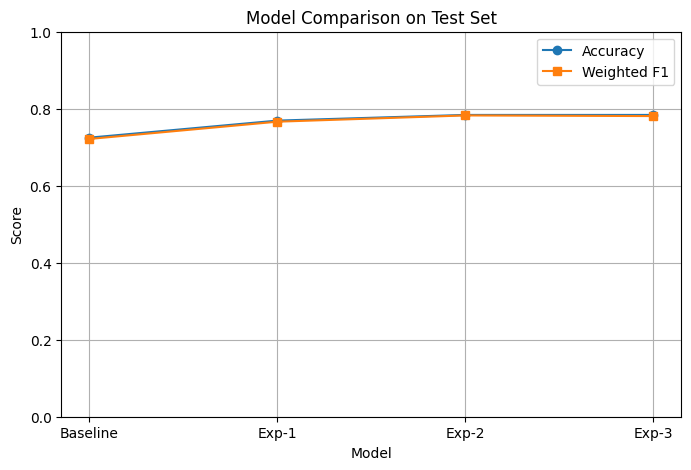

In [ ]:
names = list(results.keys())
accs = [results[n]["acc"] for n in names]
f1s  = [results[n]["f1"]  for n in names]

plt.figure(figsize=(8,5))
plt.plot(names, accs, marker='o', label="Accuracy")
plt.plot(names, f1s, marker='s', label="Weighted F1")
plt.ylim(0,1)
plt.title("Model Comparison on Test Set")
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend()
plt.grid()
plt.show()


Confusion Matrix (Final Adayı İçin)

Final Adayı: Exp-2


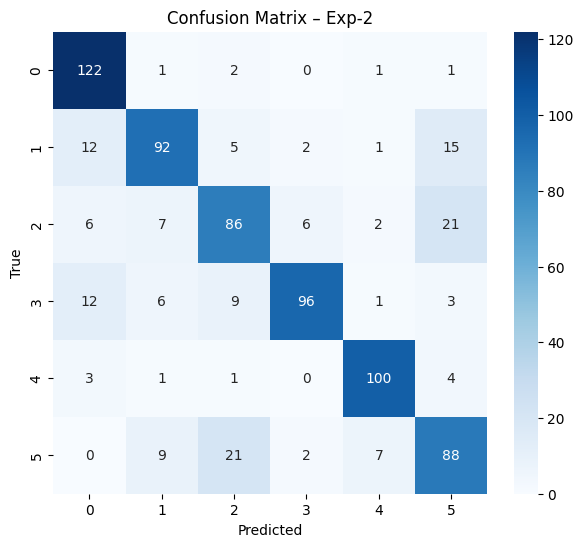

In [ ]:
best_model_name = max(results, key=lambda x: results[x]["f1"])
print("Final Adayı:", best_model_name)

y_true = results[best_model_name]["y_true"]
y_pred = results[best_model_name]["y_pred"]

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix – {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Bu çalışmada, Wav2Vec2 tabanlı konuşma duygu tanıma modeli için üç farklı deneysel konfigürasyon ve bir temel model olmak üzere toplam dört yapı değerlendirilmiştir. Her model, aynı eğitim–doğrulama bölünmesi kullanılarak eğitilmiş ve doğrulama kümesi üzerindeki en iyi başarı değerleri karşılaştırılmıştır. Elde edilen sonuçlara göre, Exp-2 konfigürasyonu %80.65 doğrulama doğruluğu ile tüm modeller arasında en yüksek performansı sağlamıştır.

Exp-2’nin üstün performansı, eğitim sürecinde izlenen daha dengeli ve kontrollü öğrenme stratejisinden kaynaklanmaktadır. Bu yapılandırmada, önceden eğitilmiş Wav2Vec2 omurgası daha düşük bir öğrenme oranı ile güncellenmiş, böylece modelin önceden öğrenilmiş temsilleri korunarak aşırı uyum riski azaltılmıştır. Aynı zamanda, omurganın daha geç çözülmesi (daha uzun süre dondurulması) sayesinde sınıflandırıcı katmanların veri kümesine uyum sağlaması için yeterli adaptasyon süresi tanınmıştır.

Buna ek olarak, daha büyük gradyan birikimi (gradient accumulation) kullanımı, etkin batch boyutunu artırarak öğrenme sürecinin daha kararlı ilerlemesini sağlamış ve genelleme performansını olumlu yönde etkilemiştir. Uygulanan düzenlileştirme stratejileri ve zaman maskesi tabanlı veri artırımı (SpecAugment), modelin gürültüye karşı dayanıklılığını artırarak doğrulama başarımını güçlendirmiştir.

Tüm bu faktörlerin birleşimi, Exp-2 modelinin hem öğrenme kararlılığı hem de genelleme başarımı açısından en dengeli yapı olduğunu göstermektedir. Bu nedenle, çalışmanın nihai modeli olarak Exp-2 konfigürasyonu seçilmiştir.

In [ ]:
from google.colab import files
files.download("/content/best_wav2vec2_exp2.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>